## Klastrowanie

W tej części przeprowadzone będzie rozwiązanie problemu predykcjenego nienadzorowanego za pomocą algorytmów klastrowania. Ideą jest sprawdzić czy możliwy jest podział danych na klasy (np. dobra / średnia / zła jakość powierza).

In [1]:
import pandas as pd

train = pd.read_csv('data/train_cleaned.csv')
val = pd.read_csv('data/val_cleaned.csv')
test = pd.read_csv('data/test_cleaned.csv')

df = pd.concat([train, val, test], axis=0)
df.head(10)

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
0,0.64,807.0,658.0,33.0,1113.0,45.0,1328.0,428.0,32.4,26.3,1.2523,3.1
1,2.50,998.0,1119.0,207.0,832.0,120.0,1780.0,1057.0,31.6,24.1,1.0994,14.1
2,1.10,968.0,669.0,67.0,1261.0,81.0,1246.0,538.0,12.3,46.8,0.6686,3.3
3,0.98,925.0,749.0,49.4,826.0,48.4,1482.0,739.0,23.5,58.3,1.6672,4.7
4,1.90,1100.0,1022.0,492.0,752.0,193.0,1101.0,1367.0,12.2,30.0,0.4245,11.2
5,2.80,1171.0,1064.0,160.0,881.0,110.0,1639.0,1097.0,16.0,42.4,0.7674,12.4
6,1.40,1097.0,721.0,183.0,746.0,96.0,1266.0,807.0,21.6,46.8,1.1959,4.2
7,0.70,844.0,538.0,158.0,1164.0,109.0,726.0,479.0,3.7,35.2,0.2833,1.4
8,4.00,1305.0,1188.0,403.6,546.0,124.8,1843.0,1524.0,31.0,33.1,1.4620,16.3
9,1.60,1235.0,828.0,118.0,1055.0,83.0,1527.0,1093.0,12.4,60.0,0.8627,6.4


## Standaryzacja

Przed wykonaniem klastrowania obowiązkowa jest standaryzacja cech, ponieważ zmienne mają rózne skale. Wykonuje się ona w celu uniknięcia dominowania cech o większych wartościach liczbowych nad cechami z mniejszymi.

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

## K-means clustering

Ponieważ klastrowanie nie jest głównym celem projektu a raczej dodatkowym, używamy tylko jednego algorytmu do klastrowania - K-means. Metoda ta działa dane na K (z góry ustawione) klastrów tak, by punkty w każdym klastrze były najbardziej do siebie podobne (zwykle wg. odległości euklidesowej).

Istnieje kilka metod do wyznaczania liczby K, ponieważ jest to podstawowym założeniem tego algorytmu. Najlepszy wybór oczywiście opiera się znajomości charakteru danych i końcowego celu. My chcemy zaklasyfikować dane do trzech grup w celu oceniania jakości powietrza:
- Czyste / dobra jakość powietrza
- Trochę zabrudnione lub toksyczne / średnia jakość powietrza
- Zabrudnione lub toksyczne / zła jakość powietrza

W przypadku, gdy nie możemy ustalić liczbę klastrów sami, można skorzystać z gotowych metod, jednak są one bardziej subiektywne niż obiektywne. Jedną z takich metod jest metod łokcia lub Elbow Method

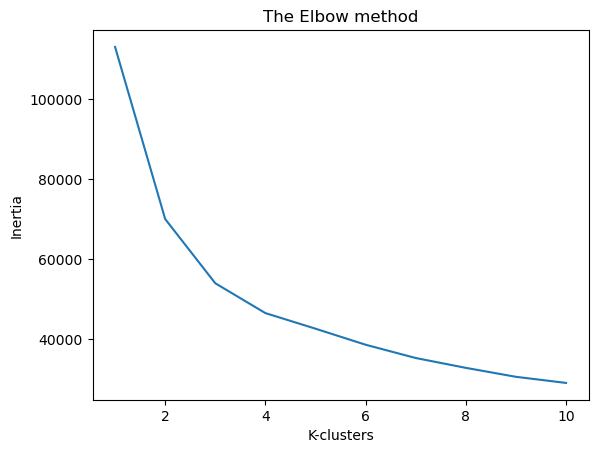

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for i in range(1,11):
    km = KMeans(n_clusters = i, random_state=42)
    km.fit(df)
    sse.append(km.inertia_)

plt.plot(range(1,11), sse)
plt.xlabel("K-clusters")
plt.ylabel("Inertia")
plt.title("The Elbow method")
plt.show()

W naszym przypadku właśnie jest sytuacja kiedy tego zgięcia nie widać dobrze. Na pewno odpowiednia liczba wg. tej metody jest w przedziale od 2 do 5, choć któs mógłby i wybrać 6. Jednak, wybieramy 3 klasy, bo taki jest końcowy cel do tej części projektu.

In [4]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df)
df['Cluster'] = labels

## Wyniki klastrowania

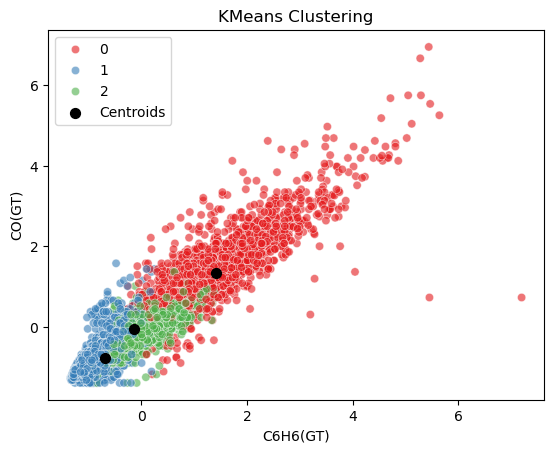

In [5]:
import seaborn as sns

sns.scatterplot(data = df, x = "C6H6(GT)", y = "CO(GT)", hue = "Cluster", palette = "Set1", alpha = 0.6)
plt.title('KMeans Clustering')
plt.xlabel('C6H6(GT)')
plt.ylabel('CO(GT)')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', label='Centroids')
plt.legend()
plt.show()

Na powyższym wykresie przedstawiono zależność CO(GT) od C6H6(GT), czyli stężenia tlenku węgla od stężenia benzenu. Im wyższa koncetracja tych elemntów w powietrzu tym gorsza jest jakość tego powietrza. Mimo tego, benzen podwyższa toksyczność. Widać, że udało się podzielić dane na 3 klasy, gdy:
- Klasa 0 (czerwony kolor) - zła jakość powietrza (wartości CO i C6H6 są duże)
- Klasa 1 (niebieski kolor) - dobra jakość powietrza (wartości CO i C6H6 są małe)
- Klasa 2 (zielony kolor) - środkowa klasa, czyli niedoskonale czyste powietrze (średnie wartości)

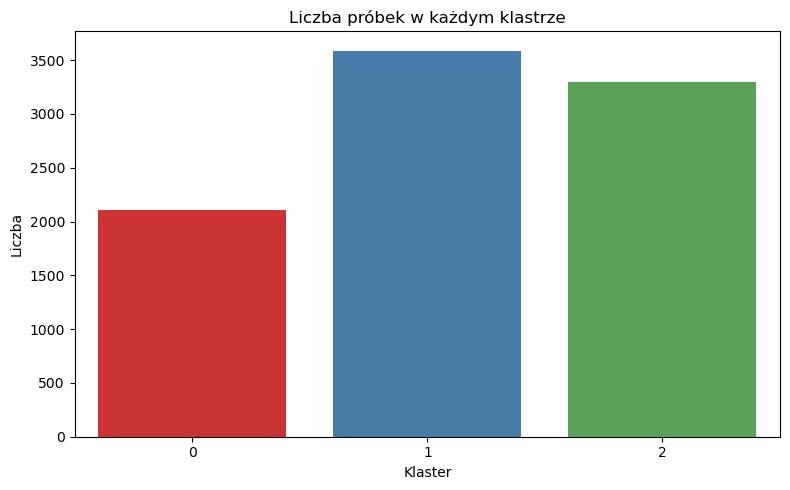

In [6]:
cluster_counts = df["Cluster"].value_counts().sort_index()
cluster_df = cluster_counts.reset_index()
cluster_df.columns = ['Cluster', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_df, x='Cluster', y='Count', hue = "Cluster", palette="Set1", legend=False)
plt.title('Liczba próbek w każdym klastrze')
plt.xlabel('Klaster')
plt.ylabel('Liczba')
plt.tight_layout()
plt.show()

Według liczby elementów Klasa 1 jest największa (ponad 3500 elementów), zatem idzie klasa 2 (około 3200) i klasa 0 (2100 elementów).

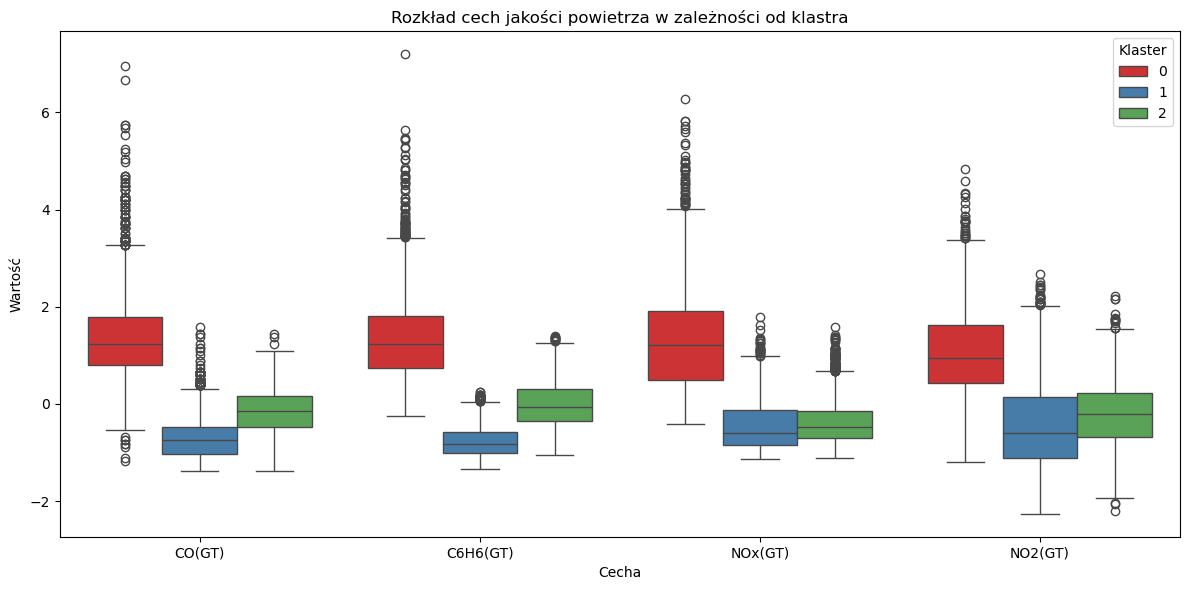

In [7]:
import seaborn as sns

features = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

df_melted = df.melt(id_vars='Cluster', value_vars=features, 
                    var_name='Cecha', value_name='Wartość')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Cecha', y='Wartość', hue='Cluster', palette='Set1')
plt.title('Rozkład cech jakości powietrza w zależności od klastra')
plt.legend(title='Klaster')
plt.tight_layout()
plt.show()

Rozkład cech, za pomocą których można ocenić jakość powietrza (im większe wartości tym gorsza jakość) pokazuje, że dla wszystkich zmiennych klaster 0, czyli zła jakość ma największe wartości. Zakres wartości i mediana jest dużo wyżej w porównaniu do 1 i 2 klastru. Dobra i średnia jakość natomiast znajdują się blisko siebie, a w niektórych przypadkach (NOx i NO2) nawet są bardzo podobne. Wykres ten potwierdza, że dało się podzielić dane na 3 określone grupy, rozkład analizowanych cech w podziale o klasy to pokazuje.